### **Course**: BIO-341 [_Dynamical systems in biology_](https://moodle.epfl.ch/course/info.php?id=14291)

**Professor**: _Julian Shillcock_ & _Felix Naef_

SSV, BA5, 2023

1. Write a Python function that takes as an input a dynamical system (the vectorial equation
˙X
= F(X)) (e.g. system1 defined in the code) and a closed curve (given as a matrix containing
the x and y coordinates of successive points on the curve) (e.g. curve defined in the code)
and as an output tells if such curve is the boundary of a Poincaré-Bendixon surface. Hint:
it might be helpful to first write a function that, given 3 vectors on a plane A, B, C, tells if
their order is ABC or ACB in a counter-clockwise direction.
Notice that this function can evaluate the vector field only on a finite number of points,
and its answer may be uncorrect if the number of points defining the curve is too small
and/or the vector field is too variable.

2. For all 3 systems (defined in the code) plot the curve (again defined in the code as curve) and
the vector field on it to visually know what you expect your function to give as an output.

3. Verify with the function you wrote that curve (defined in the code) is the boundary of a
Poincaré-Bendixon surface for system1 with the vector field pointing inwards, for system2
with the vector field pointing outward and it is not for system3. (optional) To further check
your code you can test the first 3 systems with curve2 and make sure you obtain the same
results.

4. For the glycolysis system studied in class and defined in the code find a trapping region and
test your function on it.

5. For the glycolysis system studied in class and defined in the code plot the curve defining a
trapping region (the same trapping region as question 4) and the vector field on it to visually
check your result.
Reminder: the vector field must be plotted only ON the curve you want to check, not in the rest
of the space.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

# Definition of the systems
def system1(X):
    x_dot = -2 * X[0] - 4 * X[1]
    y_dot = X[0] - 2 * X[1]
    return np.array([x_dot, y_dot])

def system2(X):
    x_dot = 2 * X[0] - 4 * X[1]
    y_dot = X[0] + 2 * X[1]
    return np.array([x_dot, y_dot])

def system3(X):
    x_dot = -3 * X[1]
    y_dot = -X[0] + X[1]
    return np.array([x_dot, y_dot])

# Closed curve
npoints = 10000
alpha = np.linspace(0, 2 * np.pi, npoints)
curve = np.array([np.cos(alpha), np.sin(alpha)]).T
curve2 = np.array([np.cos(np.flip(alpha)), np.sin(np.flip(alpha))]).T

# Glycolysis model
def glycolysis(X):
    a = 0.5
    b = 1  # You can change these parameters
    x = X[0]
    y = X[1]
    x_dot = -x + a * y + x**2 * y
    y_dot = b - a * y - x**2 * y
    return np.array([x_dot, y_dot])


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define your function
def isPB(system, curve):
    # ... your code ... #
    return "yes it is and the vector field points..."  # either inwards or outwards

def check_Point(system, curve, i):
    N_points = curve.shape[0]
    P1 = curve[i]  # current point
    P2 = curve[(i + 1) % N_points]  # next point
    P0 = curve[(i - 1) % N_points]  # previous point
    VF = system(P1)  # evaluate the vector field at that point
    v = P2 - P1
    w = P0 - P1
    theta = np.arctan2(w[1], w[0])  # notice that this function takes the point coordinate as (y, x)
    phi = (np.arctan2(v[1], v[0]) - theta) % (2 * np.pi)
    gamma = (np.arctan2(VF[1], VF[0]) - theta) % (2 * np.pi)
    if gamma < phi: 
        return 1
    elif gamma > phi: 
        return -1
    else: 
        return 0

def System_check(x):
    return np.array([1, 0])

def isPB(system, curve):
    N_points = curve.shape[0]  # number of points defining the curve
    orient = np.zeros(N_points + 1)  # will contain the orientation of the vector field at each point plus check
    for i in range(N_points):  # for every point on the curve
        orient[i] = check_Point(system, curve, i)
    # if the orientation changes from internal to external along the curve then it is not Poincaré-Bendixon
    if np.min(orient) * np.max(orient) == -1:
        print("no it is not")
        return orient
    else: 
        k = np.argmax(curve[:, 0])
        j = np.argmax(np.abs(orient))
        orient[-1] = check_Point(System_check, curve, k)
        if orient[-1] * orient[j] == -1: 
            print("yes it is, and the vector field points inwards")
        if orient[-1] * orient[j] == 1: 
            print("yes it is, and the vector field points outwards")
        return orient

def plot_curve(system, curve):
    ptx = np.arange(20) * int(curve.shape[0] / 20)
    xp = xs = curve[:, 0]
    yp = ys = curve[:, 1]
    xp = xp[ptx]
    yp = yp[ptx]
    dx, dy = system([xp, yp])
    dx, dy = dx / np.sqrt(dx**2 + dy**2), dy / np.sqrt(dx**2 + dy**2)
    plt.plot(xs, ys)
    plt.quiver(xp, yp, dx, dy)


yes it is, and the vector field points inwards


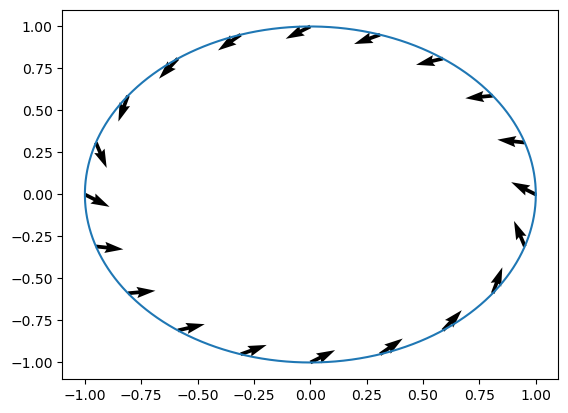

In [3]:
isPB (system1, curve)
plot_curve(system1, curve)
plt.show()

yes it is, and the vector field points outwards


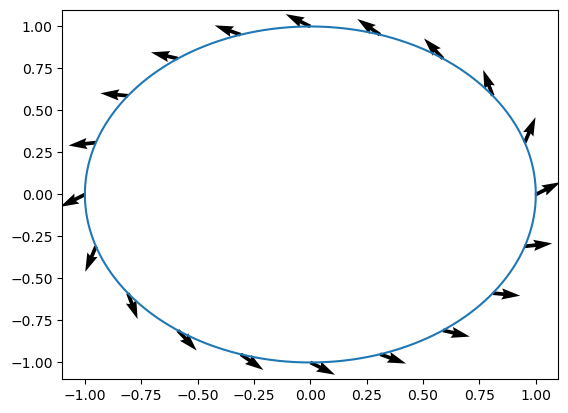

In [4]:
isPB (system2, curve)
plot_curve(system2, curve)
plt.show()

no it is not


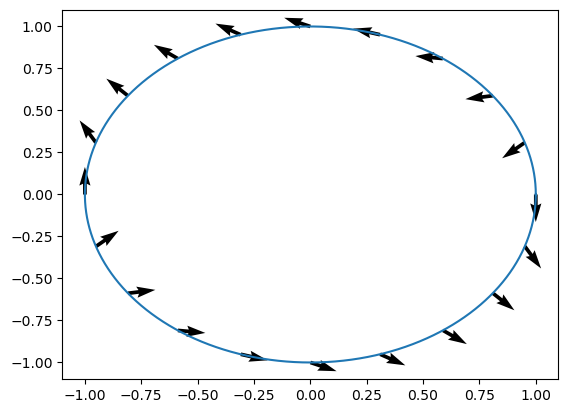

In [5]:
isPB (system3, curve)
plot_curve(system3, curve)
plt.show()

In [6]:
from math import ceil
import numpy as np

def trapping(a, b):
    N = 10000  # density of points

    # vertical line from (0,0) to (0,b/a)
    npoints = ceil(b / a) * N
    x = np.zeros((npoints,))
    y = np.linspace(0, b / a, npoints)
    L1 = np.array([x, y]).T

    # horizontal line from (0,b/a) to (b,b/a)
    npoints = ceil(b) * N
    x = np.linspace(0, b, npoints)
    y = np.full((npoints,), b / a)
    L2 = np.array([x, y]).T

    # diagonal
    # find intersection between the diagonal and the nullcline:
    coeff = [-1 / (1 + a), b / a, -1, b]  # coefficients of the polynomial with root
    # being the x-coordinate of the intersection between the x-nullcline and the diagonal.
    roots = np.roots(coeff)
    xi = float(np.real(roots[np.imag(roots) == 0]))  # intersection point
    xi += 0.01  # add a small shift to avoid problems due to numerical error
    yi = -xi + b / a + b
    L = np.sqrt((b - xi)**2 + (b / a - yi)**2)  # length of the segment
    x = np.linspace(b, xi, ceil(L) * N)
    y = np.array([-X + b / a + b for X in x])
    L3 = np.array([x, y]).T

    # vertical line
    npoints = ceil(yi) * N
    x = np.full((npoints,), xi)
    y = np.flip(np.linspace(0, yi, npoints))
    L4 = np.array([x, y]).T

    # horizontal line
    npoints = ceil(xi) * N
    x = np.flip(np.linspace(0, xi, npoints))
    y = np.zeros((npoints,))
    L5 = np.array([x, y]).T

    # Concatenate all lines to form a curve
    curve = np.concatenate((L1, L2, L3, L4, L5), axis=0)
    # Remove duplicate points
    indexes = np.unique(curve, return_index=True, axis=0)[1]
    curve = curve[sorted(indexes)]

    return curve


yes it is, and the vector field points inwards


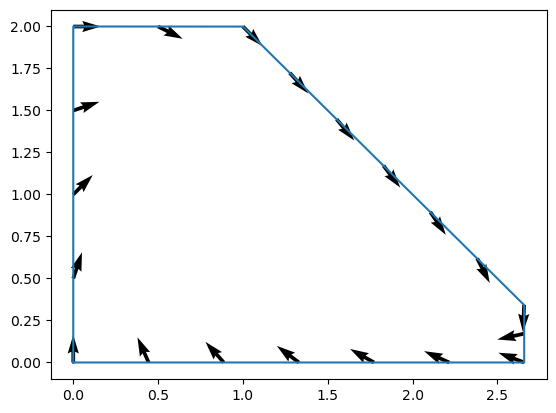

In [7]:
curveg = trapping(a=0.5,b=1)
orientation = isPB(glycolysis,curveg)
plot_curve(glycolysis,curveg)
plt.show()